In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import eli5
import scipy.stats as st
from eli5.formatters.as_dataframe import explain_weights_df
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier, XGBRegressor
from category_encoders import OrdinalEncoder,OneHotEncoder
from imblearn.over_sampling import ADASYN
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_auc_score, roc_curve
from sklearn.compose import TransformedTargetRegressor

import warnings
warnings.filterwarnings('ignore')

In [156]:
df = pd.read_csv('data/RUL_classifier.csv')
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,28056.0,NaN,NaN,NaN,50.557243,28.629237,1.0,26.0,51.0,75.0,100.0
Datetime,28056,361,2015-02-21,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cycle,28056.0,NaN,NaN,NaN,166.031865,94.886557,1.0,84.0,164.0,245.0,363.0
Voltage_mean,28056.0,NaN,NaN,NaN,170.76043,4.706852,157.745683,168.055649,170.192722,172.475352,218.265191
Rotate_mean,28056.0,NaN,NaN,NaN,446.78477,17.716433,271.246607,441.536424,449.192198,456.33845,493.381312
Pressure_mean,28056.0,NaN,NaN,NaN,100.806369,4.626168,90.973896,98.660468,100.103726,101.586085,152.3146
Vibration_mean,28056.0,NaN,NaN,NaN,40.377697,2.038066,36.163723,39.368793,40.069101,40.82825,61.113082
Model,28056,4,model3,9461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,28056.0,NaN,NaN,NaN,11.200064,5.904624,0.0,6.0,11.0,16.0,20.0
DI,28056.0,NaN,NaN,NaN,1.353352,0.687165,0.0,0.787464,1.312205,1.907928,2.701757


In [157]:
cols1 = [col for col in df.columns if '_max' in col]
cols2 = [col for col in df.columns if '_min' in col]
cols3 = [col for col in df.columns if '_mean' in col]
col_list = [cols1, cols2, cols3]

def change_db(df, col_list):
  df_copy = df.copy()
  for cols in col_list:
    for col in cols:
      if 'Rotate' in col:
        df_copy[col] = np.log1p(-df_copy[col] + df_copy[col].max()) # neg skewed를 정규분포로 변환
      else:
        df_copy[col] = np.log1p(df_copy[col]) # pos skewed를 정규분포로 변환
  return df_copy

df = change_db(df, col_list)

In [158]:
target = ['Status']

# Test set. 모델별 3개의 ID 추출
np.random.seed(42)
test_id_list = []
for i in range(1,5):
  ids = list(np.random.choice(df.loc[df['Model'] == 'model' + str(1), 'ID'].unique(), 3))
  test_id_list += ids

train, test = df.query('ID not in @test_id_list'), df.query('ID in @test_id_list').copy()
test.reset_index(drop=True, inplace=True)

drop_col = ['ID','Datetime']
train = train.drop(columns=drop_col)
test = test.drop(columns=drop_col)

x_train = train.drop(target, axis=1)
y_train = train[target]
x_test = test.drop(target, axis=1)
y_test = test[target]

pipe = Pipeline([('encoder', OneHotEncoder()),
                 ('scaler', StandardScaler()),
                 ('poly', PolynomialFeatures(degree=1))]).set_output(transform='pandas')

x_train_scaled = pipe.fit_transform(x_train)
x_test_scaled = pipe.transform(x_test)

x_train_sam, y_train_sam = ADASYN(random_state=42, n_neighbors=5).fit_resample(x_train_scaled, y_train)

In [159]:
params = {'max_iter': hp.quniform('max_iter', 30, 201, 10),
          'Cs': hp.quniform('Cs', 1, 10, 1)}

In [160]:
## bayesian_search
def survival_model(params):
  params['Cs'] = int(params['Cs'])
  params['max_iter'] = int(params['max_iter'])
  
  model = LogisticRegressionCV(cv=3, random_state=42, class_weight='balanced', scoring='f1', solver='newton-cholesky')
  model.set_params(**params)
  return model

def bayesian_search(params):
  model = survival_model(params)
  score = cross_val_score(model, x_train_scaled, y_train, cv=3)
  avg_score = np.mean(score)
  
  return {'loss': -avg_score, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(fn=bayesian_search, space=params, algo=tpe.suggest, max_evals=30,
                   trials=trials, rstate=np.random.default_rng(42))

best = trials.best_trial['misc']['vals']
print('best params :', best)
print('best score :', -trials.best_trial['result']['loss'])

100%|██████████| 30/30 [02:43<00:00,  5.44s/trial, best loss: -0.4144874830388821]
best params : {'Cs': [10.0], 'max_iter': [150.0]}
best score : 0.4144874830388821


In [161]:
cls_model = LogisticRegressionCV(cv=3, random_state=42, scoring='f1', solver='newton-cholesky', class_weight='balanced',
                                 Cs=int(best['Cs'][0]), max_iter=int(best['max_iter'][0]))

# 교차검증
scores = cross_val_score(cls_model, x_train_sam, y_train_sam, cv=5)
avg_score = scores.mean()

cls_model.fit(x_train_sam, y_train_sam)
y_pred = cls_model.predict(x_test_scaled)

train_score = cls_model.score(x_train_scaled, y_train)

print('Train', train_score)
print('CV average', avg_score)
print(classification_report(y_test, y_pred))

Train 0.40546534086844555
CV average 0.6978562557919088
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      2076
           1       0.42      0.86      0.56       549

    accuracy                           0.72      2625
   macro avg       0.68      0.77      0.68      2625
weighted avg       0.84      0.72      0.75      2625



In [164]:
def pred_plot(y_real, y_pred, threshold):
  plt.figure(figsize=(10,3))
  plt.plot(y_pred, color='r', alpha=.7, label='Predict')
  plt.plot(y_real, color='b', label='Real')
  # plt.axhline(threshold, color='orange', label='Maintenance')
  plt.title(f'Baseline Model Predict')
  plt.xlabel('List RUL Cycles')
  plt.ylabel('RUL')
  plt.legend()
  plt.show()

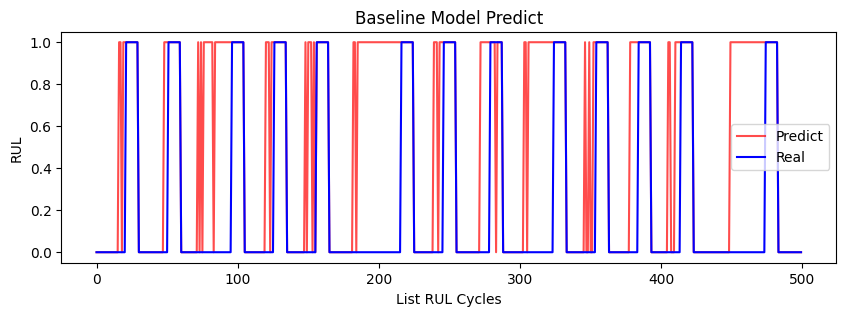

In [165]:
pred_plot(y_test[:500], y_pred[:500], 0.5)